Actor-critic cartesian rocket
---

In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [19]:
class cartesian_rocket:
    def __init__(self,
                 dry_mass = 10.,
                 wet_mass = 60.,
                 isp = 500.,
                 time_step = 0.1,
                 drag_coef = 0.,
                 max_fuel_rate = 0.5, # per second
#                  throttle_rate = 0.1 #increase of fuel use 
                 reference_height = 200, #m, for barometric pressure
                 g = 9.81
                ):
        self.dry_mass = dry_mass
        self.wet_mass = wet_mass
        self.isp = isp
        self.time_step = time_step
        self.drag_coef = drag_coef
        self.max_fuel_rate = max_fuel_rate
#         self.throttle_rate = throttle_rate
        
        #keep track of time
        self.stopwatch = 0.
        
        #keep track of velocity
        self.velocity = np.array([0.,0.])
        
        #keep track of position
        self.position = np.array([0.,0.])
        
        #drag
        self.area = 1.
        self.reference_height = reference_height
        
        #gravity
        self.g = np.array([0., -g])
        
        #history.
        self.history_position = [
            self.position
        ]
        self.history_velocity = [
            self.velocity
        ]
        
        right = np.array([1.,0.])
        up = np.array([0.,1.])
        self.directions = {
            1:right,
            2:up,
            3:-right,
            4:-up
        }
    
    #increase fuel in direction. Adds to velocity at the cost of fuel
    def fire(self, direction_code):
        direction = self.directions[direction_code]
        fuel_used = self.max_fuel_rate * self.time_step
        if fuel_used > self.wet_mass:
            fuel_used = self.wet_mass
        self.wet_mass -= fuel_used
        force = direction*self.time_step*self.isp*np.linalg.norm(self.g)*fuel_used
        accel = force / (self.wet_mass + self.dry_mass)
        self.velocity = self.velocity + accel
        
    def apply_drag(self):
        atm = np.exp(-self.position[1]/self.reference_height)
        drag_force = -0.5*atm*self.drag_coef*self.area*np.linalg.norm(self.velocity)*self.velocity
        drag_dv =  self.time_step*drag_force / (self.wet_mass + self.dry_mass)
        drag_dv_norm = np.linalg.norm(drag_dv)
        velocity_norm = np.linalg.norm(self.velocity)
        if drag_dv_norm > 0.25*velocity_norm:
            print(f'Warning: drag dv is {100*drag_dv_norm/velocity_norm}% of velocity.')
        self.velocity = self.velocity + drag_dv
    
    def apply_gravity(self):
        self.velocity = self.velocity + self.time_step*self.g
    
    def advance(self, report = True):
        self.apply_gravity()
        self.apply_drag()
        self.position = self.position + self.velocity * self.time_step 
        self.history_position.append(self.position)
        self.history_velocity.append(self.velocity)
        self.stopwatch += self.time_step
        if report:
            state = np.array([self.position, self.velocity, [self.dry_mass, self.wet_mass]])
            state = np.reshape(state, (1,6,))                
            return state
        
    def is_crashed(self, ground_level):
        if self.position[1] < ground_level:
            return True
        else:
            return False
    
    def plot_trajectory(self, label = None, to_show = True, figsize = (12,12)):
        x = np.array(self.history_position)[:,0]
        y = np.array(self.history_position)[:,1]
        if to_show:
            plt.figure(figsize = figsize)
            plt.plot(x,y, label = label)
            plt.show()
        else:
            plt.plot(x,y, label = label)

In [20]:
#inputs are the state of the rocket. Six values returned from advance()
num_inputs = 6
#actions are fire right, up, left, down, none
num_actions = 5
num_hidden = 32

inputs = keras.layers.Input(shape = (num_inputs,))
common1 = keras.layers.Dense(num_hidden, activation = 'relu')(inputs)
# action = keras.layers.Dense(num_actions, activation = 'softmax')(common1)
# critic = keras.layers.Dense(1)(common1)
common2 = keras.layers.Dense(num_hidden, activation = 'relu')(common1)
action = keras.layers.Dense(num_actions, activation = 'softmax')(common2)
critic = keras.layers.Dense(1)(common2)

model = keras.Model(inputs = inputs, outputs = [action, critic])

In [21]:
target_vel = np.array([250., 0.])
target_alt = 250.

#gives error values for the velocity and altitude
def calculate_errors(rocket_state, target_velocity = target_vel, target_altitude = target_alt):
    pos_x, altitude, vel_x, vel_y, dry_mass, wet_mass = rocket_state[0]
    velocity = np.array([vel_x, vel_y])
    speed_square_error = np.linalg.norm(velocity - target_velocity)**2
    altitude_square_error = (altitude - target_altitude)**2
    return speed_square_error, altitude_square_error
    

In [22]:
seed = 2022
gamma = 0.99
max_simulation_time = 60*2 #seconds
eps = np.finfo(np.float32).eps.item()

In [23]:
rng = np.random.default_rng(seed)

average loss: 3424435.500/sec at episode 10, rocket lasted 2.30 sec
average loss: 2293481.250/sec at episode 20, rocket lasted 2.30 sec
average loss: 2699749.750/sec at episode 30, rocket lasted 2.30 sec
average loss: 2630199.250/sec at episode 40, rocket lasted 2.30 sec
average loss: 2455156.500/sec at episode 50, rocket lasted 2.30 sec
average loss: 2622138.000/sec at episode 60, rocket lasted 2.30 sec
average loss: 2566608.000/sec at episode 70, rocket lasted 2.30 sec
average loss: 2520333.000/sec at episode 80, rocket lasted 2.30 sec
average loss: 2553172.000/sec at episode 90, rocket lasted 2.30 sec
average loss: 2541636.000/sec at episode 100, rocket lasted 2.30 sec


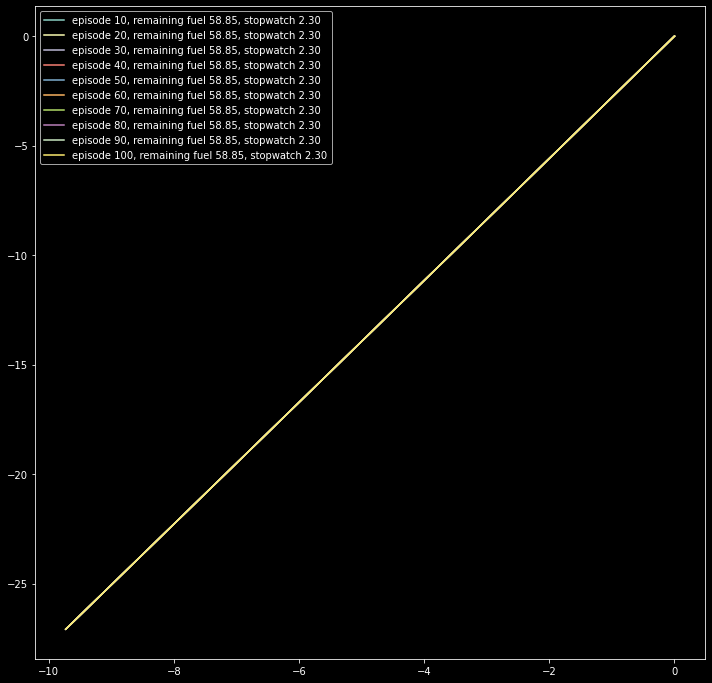

In [26]:
optimizer = tf.optimizers.Adam(learning_rate = 0.1)
huber = tf.losses.Huber()
action_probs_history = []
critic_value_history = []
errors_history = []
episode_count = 0

plt.figure(figsize = (12,12))

num_episodes = 100
episode_update_period = 10

for epoch in range(num_episodes):
    rkt = cartesian_rocket()
    starting_state = np.array([rkt.position, rkt.velocity, [rkt.dry_mass, rkt.wet_mass]])
    starting_state = np.reshape(starting_state, (1,6))
    state = tf.convert_to_tensor(starting_state)
    
    episode_error = 0
    
    with tf.GradientTape() as tape:
        while not rkt.is_crashed(ground_level = -25.) and rkt.stopwatch <= max_simulation_time:
                
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0,0])

            action = rng.choice(num_actions, p = np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            #fire in the appropriate direction unless the action is number 5: coast
            if action == 0:
                pass
            else:
                rkt.fire(action)

            state = rkt.advance()
            
            velocity_error, altitude_error = calculate_errors(state)
            total_error = velocity_error+altitude_error
            errors_history.append(total_error)
            episode_error += total_error
        
#         running_reward = 0.05 * episode_reward + (1-0.05) * running_reward
        
        errors = []
        discounted_sum = 0
        for r in errors_history[::-1]:
            discounted_sum = r + gamma*discounted_sum
            errors.insert(0, discounted_sum)
        errors = np.array(errors)
#         errors = (errors - np.mean(errors)) / (np.std(errors) + eps)
        errors = errors/len(errors)
        errors = errors.tolist()
        
        history = zip(action_probs_history, critic_value_history, errors)
        actor_losses = []
        critic_losses = []
        for log_prob, critic_error, true_error in history:
            abs_diff = abs(critic_error - true_error)
            actor_losses.append(-log_prob*abs_diff)
            critic_losses.append(
                huber(tf.expand_dims(critic_error, 0), tf.expand_dims(true_error,0))
            )
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
               
        
    episode_count += 1
    if episode_count % episode_update_period == 0:
        template = 'average loss: {:.3f}/sec at episode {}, rocket lasted {:.2f} sec'
        print(template.format(loss_value/rkt.stopwatch, episode_count, rkt.stopwatch))
#         model.save(f'./actor_critic_rocket_models/model_{episode_count}.tf')
        rkt.plot_trajectory(label='episode {}, remaining fuel {:.2f}, stopwatch {:.2f}'.format(episode_count,rkt.wet_mass,rkt.stopwatch), to_show=False)

#         print(action_probs_history)
        
        action_probs_history.clear()
        critic_value_history.clear()
        errors_history.clear()
    
# plt.xlim(-10, 500)
# plt.ylim(-10, 500)
plt.legend();